- 실시간 수면/활동 라이프 로그 데이터 수집을 통한 인지능력 모니터링 과제 


## 데이터 설명
- 입력 데이터 feature
  - 반지 형태의 데일리 수면/활동 데이터 수집기를 통해 착용자의 수면 데이터(수면 시작/종료 시간, 수면 점수, 수면방해, 수면 효율, 램수면 시간, 수면의 깊이 등)와 활동 데이터(활동 시작/종료 시간, 운동 시간, 활동 점수, 신진대사량, 회복 시간, 움직인 거리, 칼로리 소모량 등)을 5분 단위로 수집하여 활동->수면->활동 과 같이 사람의 기본적인 삶의 패턴을 24시간 동안 라이프 로그 모니터링한 데이터.


- 출력 데이터 label
  - CN : Cognitive Normal(인지기능 정상)
  - MCI : Mild Cognitive Impairment(경도 인지기능 장애)
  - Dem : Dementia(치매)

## 라이브러리

In [9]:
# 필요한 라이브러리 불러오기
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.optim as optim
import torch.utils as utils
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn import preprocessing
from sklearn.metrics import f1_score
from datetime import datetime, timezone, timedelta
import sys
import random

### 기타
- SEED 고정 : 시드를 고정하여 실행하면, 같은 코드를 여러 번 실행한 결과에 일관성을 부여합니다.
- device 설정 : GPU를 사용하기 위해서 지정합니다.
- 디렉토리 설정 : 추후 반복적으로 사용하게 될 현재 디렉토리 경로를 저장합니다.
  데이터는 현재 디렉토리의 `data/`폴더 안에 저장합니다.  
- working directory 구조  
  |--code.ipynb  
  |--data/  
  |--|--train/  
  |--|--|--train.csv  
  |--|--test/  
  |--|--|--test.csv

In [10]:
# SEED 고정
RANDOM_SEED = 10
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# GPU 사용 지정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# 경로 설정
ROOT_PATH =  "C:/Users/Joy/lifelog_worksheet.ipynb"
DATA_DIR = "C:/Users/Joy/Documents/DataScience/data"

# train / val set 분할 비율 설정
TRAIN_RATIO = 0.9

### EDA (Explaratory Data Analylsis)

* 148명에 대한 데일리 라이프로그 데이터

In [11]:
train_df = pd.read_csv('C:/Users/Joy/Documents/DataScience/data/train/train.csv')
test_df = pd.read_csv('C:/Users/Joy/Documents/DataScience/data/test/test.csv')
                      
train_df

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_delta,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8)
0,nia+404@rowan.kr,2020-11-27,1.71875,730,2944,...,14346,0,417,0,...,-0.12,-0.12,99.99,NaN,\r,2/1/1/1/1/1/2/2/1/1/1/1/1/1/2/2/2/3/2/2/2/2/2/...,0.9/0.9/1.4/1.9/1.1/0.9/0.9/1.1/1.3/1/0.9/1.1/...,0/73/73/73/72/71/70/71/71/71/70/70/73/72/74/74...,4/2/4/3/3/1/2/2/2/2/2/2/3/3/3/4/4/3/2/2/2/2/2/...,0/10/10/10/11/11/10/12/18/13/14/12/10/10/18/17...
1,nia+404@rowan.kr,2020-11-28,1.40625,342,2449,...,6352,0,473,0,...,-0.32,-0.32,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/2/2/...,1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,69/70/69/69/70/72/71/72/70/69/69/69/68/68/63/6...,2/4/2/2/2/2/3/1/2/2/4/4/2/2/2/2/2/2/2/2/2/2/4/...,23/23/26/24/18/13/15/14/17/20/24/30/23/25/22/1...
2,nia+404@rowan.kr,2020-11-29,1.46875,401,2544,...,7297,0,586,0,...,0.07,0.07,99.99,NaN,\r,1/1/1/1/1/1/1/2/1/1/1/1/2/2/2/2/2/1/1/1/1/1/2/...,1.1/1.1/1.2/1.1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/74/73/73/74/74/74/71/71/70/70/69/70/68/66/69...,4/2/4/4/1/1/1/4/4/4/4/4/4/4/2/3/4/2/2/4/2/2/2/...,0/11/14/20/13/14/14/16/27/29/27/20/19/19/14/12...
3,nia+404@rowan.kr,2020-11-30,0.34375,27,1850,...,491,0,176,0,...,-0.41,-0.41,99.99,NaN,\r,2/1/2/2/1/2/1/1/2/1/1/1/1/1/2/1/1/1/1/1/2/2/2/...,0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/0/...,73/70/71/72/75/75/73/70/70/70/67/63/63/63/63/6...,4/4/4/4/3/3/3/2/4/4/4/2/2/2/2/2/2/2/2/4/2/2/2/...,24/28/19/17/12/10/17/20/23/23/25/31/26/25/34/3...
4,nia+404@rowan.kr,2020-12-01,1.46875,333,2518,...,5861,0,646,0,...,-0.27,-0.27,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/3/3/2/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,0/0/0/0/0/0/0/0/69/69/71/69/65/66/64/64/65/66/...,4/4/4/4/4/4/4/4/4/4/4/2/2/2/2/3/3/2/4/4/4/2/2/...,0/0/0/0/0/0/0/0/21/22/26/23/19/29/22/17/14/13/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,nia+206@rowan.kr,2020-12-22,1.34375,227,2316,...,3863,3,735,2,...,-0.16,-0.16,99.99,NaN,\r,2/1/1/2/2/1/1/1/1/2/2/3/2/1/1/1/1/1/1/1/1/1/1/...,1.1/1.4/1.2/0.9/1.2/1.1/0.9/0.9/0.9/1/0.9/0.9/...,0/54/54/54/55/56/0/0/55/52/52/53/54/54/56/57/6...,4/4/4/2/2/2/2/4/2/2/2/1/1/1/1/4/2/2/3/3/3/3/3/...,0/35/39/28/26/41/0/0/52/31/27/30/21/22/27/40/3...
9323,nia+206@rowan.kr,2020-12-24,1.34375,249,2351,...,4411,1,780,4,...,-0.09,-0.09,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/2/3/2/2/2/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0.9/0....,68/66/67/67/68/69/69/70/71/71/71/69/72/70/70/7...,4/4/2/2/2/1/1/1/1/1/1/2/2/3/3/2/2/2/2/2/3/4/2/...,26/16/19/18/16/18/19/17/15/16/15/13/11/13/13/1...
9324,nia+206@rowan.kr,2020-12-26,1.53125,570,2682,...,11057,1,518,1,...,0.41,0.41,99.99,NaN,\r,1/1/1/1/1/1/2/2/2/2/2/2/1/1/1/1/1/1/1/1/1/1/1/...,0.9/0.9/0.9/0.9/1.1/0.9/0.9/1.1/0.9/0.9/0.9/0....,0/0/65/65/66/67/69/72/73/72/73/74/73/74/75/75/...,4/4/2/2/2/2/2/2/2/2/2/2/4/4/4/4/2/3/3/3/2/2/4/...,0/0/13/12/12/13/12/12/12/16/13/12/13/17/13/18/...
9325,nia+206@rowan.kr,2020-12-27,1.34375,295,2331,...,5135,4,578,0,...,0.27,0.27,99.99,NaN,\r,1/1/1/2/3/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.1/0.9/0.9/0.9/1/0.9/0.9/0.9/0.9/0.9/0.9/0.9/...,0/0/0/64/64/64/64/65/65/66/66/66/66/68/68/68/6...,4/4/4/4/2/2/2/2/2/2/2/2/2/3/3/3/3/2/4/4/2/2/2/...,0/0/0/14/17/18/14/14/17/15/17/12/17/12/13/12/1...


In [12]:
train_label_df = pd.read_csv('C:/Users/Joy/Documents/DataScience/data/train/train_label.csv')                        
train_label_df

,SAMPLE_EMAIL,DIAG_NM
0,nia+315@rowan.kr,CN
1,nia+220@rowan.kr,CN
2,nia+096@rowan.kr,MCI
3,nia+163@rowan.kr,CN
4,nia+396@rowan.kr,CN
...,...,...
143,nia+394@rowan.kr,CN
144,nia+067@rowan.kr,Dem
145,nia+013@rowan.kr,MCI
146,nia+450@rowan.kr,CN


In [13]:
test_df

,EMAIL,summary_date,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,...,sleep_temperature_delta,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone,sleep_total,CONVERT(activity_class_5min USING utf8),CONVERT(activity_met_1min USING utf8),CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8)
0,nia+075@rowan.kr,2020-10-19,1.738393,627.0,2718.0,...,17125.461981,0.0,588.0,1,...,-0.022292,-0.346215,99.99,NaN,\r,1/1/1/1/1/1/1/1/2/1/1/1/1/1/1/1/1/1/1/1/1/1/2/...,1.4/1.8/1.2/3.9/0.9/0.1/0.9/0.9/1.3/1.2/0.9/0....,71/0/65/64/71/64/0/60/66/69/64/66/61/64/62/66/...,2/2/3/2/3/1/3/2/4/4/2/2/4/4/3/2/1/2/4//2/4/2/2...,44/19/19/16/0/20/32/26/13/14/25/17/22/25/17/14...
1,nia+075@rowan.kr,2020-10-20,1.442223,137.0,2672.0,...,11410.099490,0.0,544.0,1,...,0.481816,0.019516,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.6/0.9/0.9/1.3/3.9/2.9/0.9/0.9/0.9/1.1/0.9/1/...,65/56/56/60/59/58/59/58/57/59/62/60/59/56/54/5...,4/3/3/2/1/2/2/1/3/4/2/3/3/1/3/3/1/2/2/2/2/2/3/...,21/17/23//34/19/17/15/19/19/17/30/29/13/19/21/...
2,nia+075@rowan.kr,2020-10-21,1.479700,175.0,2514.0,...,5497.769969,2.0,559.0,2,...,-0.082092,0.022043,99.99,NaN,\r,1/1/1/1/1/2/2/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/1/...,1.5/0.9/1.4/0.9/0.9/0.9/3.6/1.5/0.9/0.9/0.9/1....,64/0/57/66/52/0/62/0/61/61/0/54/54/52/0/55/64/...,3/1/4/2/2/2/4/4/3/2/2/3/1/2/1/2/3/4/1/2/2/4/2/...,0/21/0/19/53/30/0/27/0/0/70/0/0/44/0/24/31/0/1...
3,nia+075@rowan.kr,2020-10-22,1.069079,217.0,2653.0,...,3852.789155,0.0,671.0,0,...,0.177269,0.013762,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,4.8/1.9/1/1.3/1.4/1.8//2.2/2.1/1.2/1.2/1.2/2.3...,61/61/63/64/59/62/59/60/62/63/58/65/64/61/61/6...,4/1/2/1/4/2/1/2/1/1/2/2/4/4/2/1/2/3/1/3/2/3/4/...,27/20/15/15/16/17/18/22/16/16/16/37/18/18/16/1...
4,nia+075@rowan.kr,2020-10-23,1.645156,16.0,2327.0,...,4483.044208,0.0,767.0,0,...,-0.037126,-0.110565,99.99,NaN,\r,1/1/1/1/1/2/1/1/2/2/1/1/1/1/1/1/1/1/1/1/1/1/1/...,1.9/1.4/1.2/1.3/1.4/1.7/1.2/1/1.8/1.2/0.9/0.9/...,58/0/60/57/60/63/57/55/56/57/57/0//57/58/56/58...,4/4/2/2/4/4/4/4/2/2/2/4/2/1/4/2/4//2/2/4/4/4/4...,25/33/13/19/14/29/25/19/0/22/0/29/0/37/0/27/0/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29087,nia+513@rowan.kr,2021-01-15,1.828141,720.0,3254.0,...,10419.028594,20.0,513.0,0,...,-0.817544,0.063381,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/...,0.9/1.3/3.6/1.8/1.8/3.8/1.1/4.4/1.2/5.3/0.1/1....,54/54/53//56/50/54/61/54/51/53/53/53/53/55/50/...,3/1/3/1/2/3/3/1/2/1/3/2/4/3/2/2/3/1/2/1/2/2/1/...,37/16/43/0/33/92/27/19/0/33/23/17/40/15/36/21/...
29088,nia+513@rowan.kr,2021-01-16,1.964531,1424.0,3221.0,...,9001.492840,6.0,853.0,0,...,0.334409,-0.257062,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/1/...,1.3/0.9/1.2/1/2.4/1.4/1.3/1.2/1.4/1.6/6.5/1.2/...,0/52/56/53/56/65/53/63/0/58/0/51/0/0/62/0/55/6...,2/4/2/4/4/2/2/1/1/1/1/2/4/2/2/2/3/1/2/2/4//2/3...,17/40/23/26/0/0/0/0/31/0/74/26/0/24/0/42/67/48...
29089,nia+513@rowan.kr,2021-01-17,1.406274,448.0,2878.0,...,17803.219135,12.0,705.0,0,...,0.436898,0.487908,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/1/2/2/1/1/2/1/...,1.2/2.8/0.9/1.1/0.9/1.2/1.4/1.4/3/1.2/1.3/1.2/...,54/56/54/0/53/54/55/57/54/54/56/56/53/0/56/61/...,2/2/2/1/4/2/4/2/1/4/2/2/2/2/4/4/2/2/4/4/1/2/4/...,0/18/18/19/0/19/0/17/26/17/38/22/19/17/23/18/1...
29090,nia+513@rowan.kr,2021-01-18,1.655102,1053.0,3141.0,...,9680.800729,6.0,648.0,0,...,-0.109693,0.298931,99.99,NaN,\r,1/1/1/1/1/1/1/1/1/1/1/1/2/2/1/2/2/2/1/1/1/1/1/...,1.3/0.9/1.2/6.7/3.3/1.3/2.4/1.2/5/1.3/0.9/0.9/...,/0/55/55/55/53/0/0/54/51/54/55/52/60/54/55/56/...,2/4/1/1/1/2/4/4/2/1/1/1/2/1/4/2/4/2/1/1/4/2/4/...,32/19/24/33/27/30/22/0/27/24/23/16/37/51/0/31/...


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9327 entries, 0 to 9326
Data columns (total 65 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   EMAIL                                     9327 non-null   object 
 1   summary_date                              9327 non-null   object 
 2   activity_average_met                      9327 non-null   float64
 3   activity_cal_active                       9327 non-null   int64  
 4   activity_cal_total                        9327 non-null   int64  
 5   activity_class_5min                       9327 non-null   object 
 6   activity_daily_movement                   9327 non-null   int64  
 7   activity_high                             9327 non-null   int64  
 8   activity_inactive                         9327 non-null   int64  
 9   activity_inactivity_alerts                9327 non-null   int64  
 10  activity_low                        

In [15]:
train_df.describe()

,activity_average_met,activity_cal_active,activity_cal_total,activity_daily_movement,activity_high,activity_inactive,activity_inactivity_alerts,activity_low,activity_medium,activity_met_min_high,...,sleep_score_deep,sleep_score_disturbances,sleep_score_efficiency,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,sleep_temperature_deviation,sleep_temperature_trend_deviation,timezone
count,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,...,9327.000000,9327.00000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9327.000000,9.327000e+03,0.0
mean,1.462411,459.686287,2495.035810,8679.232015,3.106465,521.989600,0.499732,281.775919,51.671491,20.825667,...,81.454594,65.62035,75.016833,79.648333,56.095529,71.941889,-0.011046,-0.011046,9.999000e+01,NaN
std,0.188109,266.859350,347.780809,5249.443025,7.146556,138.412419,0.818622,119.672739,44.071946,47.185657,...,25.204028,12.75298,19.657572,14.908192,29.805528,20.397709,0.315198,0.315198,7.674273e-12,NaN
min,0.062500,0.000000,1478.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,14.00000,8.000000,1.000000,1.000000,13.000000,-1.980000,-1.980000,9.999000e+01,NaN
25%,1.343750,261.000000,2266.000000,4728.000000,0.000000,425.000000,0.000000,192.000000,17.000000,0.000000,...,70.000000,57.00000,62.000000,70.000000,31.000000,58.000000,-0.180000,-0.180000,9.999000e+01,NaN
50%,1.437500,416.000000,2465.000000,7844.000000,1.000000,514.000000,0.000000,273.000000,42.000000,7.000000,...,96.000000,66.00000,79.000000,81.000000,56.000000,74.000000,0.000000,0.000000,9.999000e+01,NaN
75%,1.562500,608.000000,2707.000000,11666.000000,3.000000,609.000000,1.000000,356.000000,76.000000,22.000000,...,98.000000,74.00000,90.000000,91.000000,84.000000,89.000000,0.170000,0.170000,9.999000e+01,NaN
max,2.656250,2292.000000,4585.000000,45494.000000,102.000000,1082.000000,6.000000,788.000000,362.000000,1062.000000,...,100.000000,99.00000,100.000000,99.000000,100.000000,100.000000,2.590000,2.590000,9.999000e+01,NaN


In [16]:
train_df.isnull().sum()        # Null 값 여부 확인

EMAIL                                       0
summary_date                                0
activity_average_met                        0
activity_cal_active                         0
activity_cal_total                          0
                                           ..
CONVERT(activity_class_5min USING utf8)     0
CONVERT(activity_met_1min USING utf8)       0
CONVERT(sleep_hr_5min USING utf8)           0
CONVERT(sleep_hypnogram_5min USING utf8)    0
CONVERT(sleep_rmssd_5min USING utf8)        0
Length: 65, dtype: int64

## 데이터 시각화

* 148명의 CN(Cognitive Normal, 인지기능 정상), MCI(Mild Cognitive Impairment, 경도 인지기능 장애), Dem(Dementia, 치매) 분포 
* CN > MCI > Dem 

C:\Users\Joy\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='DIAG_NM', ylabel='count'>

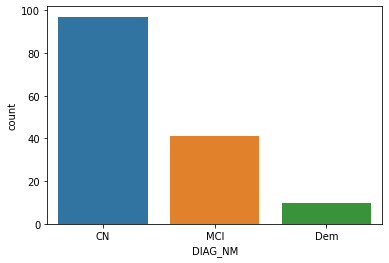

In [17]:
import seaborn as sns

sns.countplot(train_label_df['DIAG_NM'])

- 인코딩을 위한 레이블 딕셔너리 
- CN(Cognitive Normal, 인지기능 정상)을 '0'에, MCI(Mild Cognitive Impairment, 경도 인지기능 장애)을 '1'에, Dem(Dementia, 치매)을 '2'에 대응시키는 딕셔너리를 생성

In [18]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode):
        self.data_dir = data_dir
        self.mode = mode
                
        # 인코딩을 위한 레이블 딕셔너리
        self.states = {'CN':0, 'MCI':1,'Dem':2}
        self.inputs, self.labels = self.data_loader(data_dir)

    def data_loader(self, path):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
            
        if self.mode == 'train':

            inputs, labels = pd.read_csv(os.path.join(self.data_dir, self.mode, self.mode + '.csv')), pd.read_csv(os.path.join(self.data_dir, self.mode, self.mode + '_label.csv'))
            inputs, labels = self.preprocessing(inputs, labels)
            inputs = inputs[:int(len(inputs)*TRAIN_RATIO)]
            labels = labels[:int(len(labels)*TRAIN_RATIO)]

            return inputs, labels
        
        elif self.mode == 'val':

            inputs, labels = pd.read_csv(os.path.join(self.data_dir, 'train/train.csv')), pd.read_csv(os.path.join(self.data_dir, 'train/train_label.csv'))
            inputs, labels = self.preprocessing(inputs, labels)

            inputs = inputs[int(len(inputs)*TRAIN_RATIO):]
            labels = labels[int(len(labels)*TRAIN_RATIO):]

            return inputs, labels

    
    
    def preprocessing(self, inputs, labels):
        print('Preprocessing ' + self.mode + ' dataset..')
        
        # Cut time series length based on the shortest length
        train_df = pd.read_csv('C:/Users/Joy/Documents/DataScience/data/train/train.csv')
        test_df = pd.read_csv('C:/Users/Joy/Documents/DataScience/data/test/test.csv')
        time_series_length= pd.concat([train_df['EMAIL'].value_counts(), test_df['EMAIL'].value_counts()])
        shortest_length = time_series_length[-1]
        arranged_labels = []

        for id in inputs['EMAIL'].unique():
            idx = inputs['EMAIL'][inputs['EMAIL'] == id].index
            start_idx = idx[0]
            end_idx = idx[-1]
            inputs.drop(list((range(start_idx + shortest_length , end_idx+1))), axis=0, inplace=True)
            inputs = inputs.reset_index(drop=True)

        # Selecting usage columns
        del_col = ['EMAIL', 'summary_date',
                   'activity_class_5min', 'activity_met_1min',
                   'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min', 'timezone', 'sleep_total',
                   'CONVERT(activity_class_5min USING utf8)', 'CONVERT(activity_met_1min USING utf8)',
                   'CONVERT(sleep_hr_5min USING utf8)', 'CONVERT(sleep_hypnogram_5min USING utf8)',
                   'CONVERT(sleep_rmssd_5min USING utf8)']
        inputs.drop(del_col, axis=1, inplace=True)

        #Normalization
        scaler = preprocessing.StandardScaler()
        if self.mode == 'test' :
            train_df.drop(del_col, axis=1, inplace=True)
            scaler.fit_transform(train_df)
            inputs = scaler.transform(inputs)
        else:
            inputs = scaler.fit_transform(inputs)

        # Convert dataframe to tensor
        inputs = torch.FloatTensor(inputs).reshape(len(labels), -1, inputs.shape[1])
        
        
        
        labels = list(map(lambda x: self.states[x], labels['DIAG_NM'].tolist()))
        labels = torch.LongTensor(labels)
        #labels = self.label_encoder(labels)
        #labels = torch.FloatTensor(labels).rehshape(len(labels),-1)

        return inputs, labels

    def label_encoder(self, labels):
        try:
            labels = list(map(lambda x : self.states[x], labels['DIAG_NM'].tolist()))
            return labels
        except:
            assert 'Invalid states'

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index, :, :], self.labels[index]

In [19]:
# DATASET 만들기
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train')
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val')

# 데이터로드 파라미터
BATCH_SIZE = 512

# DATASET 로딩하기
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading train dataset..
Preprocessing train dataset..
Loading val dataset..
Preprocessing val dataset..


## 모델 설계
### 사용할 파라미터
- `LEARNING_RATE` : 경사하강법(Gradient Descent)을 통해 loss function의 minimum값을 찾아다닐 때, 그 탐색 과정에 있어서의 보폭 정도로 직관적으로 이해 할 수 있습니다. 보폭이 너무 크다면 최적값을 쉽게 지나칠 위험이 있고, 보폭이 너무 작다면 탐색에 걸리는 시간이 길어집니다.
- `EPOCHS` : 
  - 한 번의 epoch는 인공 신경망에서 전체 데이터 셋에 대해 forward pass/backward pass 과정을 거친 것입니다.
  - 즉, epoch이 1만큼 지나면, 전체 데이터 셋에 대해 한번의 학습이 완료된 상태입니다.
  - 모델을 만들 때 적절한 epoch 값을 설정해야만 underfitting과 overfitting을 방지할 수 있습니다.
  - 1 epoch = (데이터 갯수 / batch size) interations
- `HIDDEN_SIZE` : 
    - 신경망에서 인풋 레이어와 아웃풋 레이어 사이의 레이어들을 말합니다.
    - 기본적으로 1개의 hidden layer가 있어야 하며 hidden layer의 units의 수는 input units의 수에 배수로 지정하는 것이 일반적입니다.
    - 모든 hidden layers들은 같은 수의 units들을 가지고 있어야 합니다.
- `EARLY_STOPPING_PATIENCE` :
  - 너무 많은 epoch은 overfitting을 일으키고, 너무 적은 epoch은 underfitting을 일으킵니다. 이런 딜레마에 빠지지 않기 위도록 특정 시점에 학습을 멈추는 방법이 early stopping입니다.
  - 해당 변수는 validation score가 개선되지 않아도 학습을 몇 에폭 더 진행할 지 결정합니다. 예를 들어 EARLY_STOPPING_PATIENCE를 5로 설정하고 validation score가 10에폭에서 가장 높은 후 다음 에폭부터 줄어든다면, 15에폭까지는 학습을 진행하며 validation score가 더 높아지는지 확인하고, 그렇지 않다면 학습을 중단합니다.
- `WEIGHT_DECAY` :
  - overfitting을 억제하는 학습 기법의 하나로, 학습된 모델의 복잡도를 줄이기 위해서 학습 중 weight가 너무 큰 값을 가지지 않도록 Loss function에 Weight가 커질 경우에 대한 패널티 항목을 넣습니다.

#### 코드 채워넣기
- 모델 학습을 위한 하이퍼 파라미터를 값을 지정해 보세요.
- 지정하는 파라미터 값에 따라 모델의 학습 속도와 성능이 달라질 수 있습니다.

In [21]:
# hyper-parameters
LEARNING_RATE = 5e-5
EPOCHS = 30
HIDDEN_SIZE = 32
EARLY_STOPPING_PATIENCE = 5
WEIGHT_DECAY = 0.5

In [22]:
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, device, n_layers=1):
        super(LSTM, self).__init__()
        self.device = device
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.h_0 = self.init_hidden(BATCH_SIZE)
        self.lstm = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_dim, output_dim)

    def init_hidden(self, batch_size):
        h_0 = Variable(torch.randn(2 * self.n_layers, batch_size, self.hidden_dim)).to(self.device)
        c_0 = Variable(torch.randn(2 * self.n_layers, batch_size, self.hidden_dim)).to(self.device)
        return (h_0, c_0)

    def forward(self, x):
        #batch_size = x.shape[0]
        #self.h_c = self.init_hidden(batch_size)
        lstm_out, self.h_c = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return F.softmax(output, dim=1)

In [23]:
# 모델 생성하기
model = LSTM(input_dim=train_dataset.inputs.shape[2], hidden_dim=512, output_dim=3, device=device).to(device)

In [24]:
# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
metric_fn = f1_score

#### 코드 채워넣기
- `train_epoch`과 `valid_epoch` 함수에서 data와 target을 위에서 정의한 device에 할당해보세요.  
- train_epoch 부분과 valid_epoch 부분에 들어갈 코드는 같습니다.

In [25]:
class Trainer():
    def __init__(self, model, device, loss_fn, metric_fn, optimizer=None, scheduler=None):
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.metric_fn = metric_fn
        self.optimizer = optimizer
        self.scheduler = scheduler


    def train_epoch(self, dataloader, epoch_index=0):
        self.model.train()
        self.train_total_loss = 0
        target_lst = []
        pred_lst = []
        for batch_idx, (data, target) in enumerate(dataloader):
            data = ##### 코드 #####
            target = ##### 코드 #####
            output = self.model(data)
            self.optimizer.zero_grad()
            loss = self.loss_fn(output, target)
            self.train_total_loss += loss.item()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            target_lst.extend(target.tolist())
            pred_lst.extend(output.argmax(dim=1).tolist())
        self.train_mean_loss = self.train_total_loss / len(dataloader)
        self.train_score = f1_score(y_true=target_lst, y_pred=pred_lst, average='macro')
        msg = f'Epoch {epoch_index}, Train, loss: {self.train_mean_loss}, Score: {self.train_score}'
        print(msg)


    def validate_epoch(self, dataloader, epoch_index=0):
        self.model.eval()
        self.val_total_loss = 0
        target_lst = []
        pred_lst = []
        with torch.no_grad():
            for batch_index, (data, target) in enumerate(dataloader):
                data = ##### 코드 #####
                target = ##### 코드 #####
                output = self.model(data)
                loss = self.loss_fn(output, target)
                self.val_total_loss += loss.item()
                target_lst.extend(target.tolist())
                pred_lst.extend(output.argmax(dim=1).tolist())
            self.val_mean_loss = self.val_total_loss / len(dataloader)
            self.validation_score = f1_score(y_true=target_lst, y_pred=pred_lst, average='macro')
            msg = f'Epoch {epoch_index}, Validation, loss: {self.val_mean_loss}, Score: {self.validation_score}'
            print(msg)

SyntaxError: invalid syntax (<ipython-input-25-3e1a24b73cb0>, line 17)

In [ ]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        verbose (bool): 로그 출력 여부, True 일 때 로그 출력
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int, verbose: bool)-> None: # logger:logging.RootLogger=None
        """ 초기화

        Args:
            patience (int): loss가 줄어들지 않아도 학습할 epoch 수
            weight_path (str): weight 저장경로
            verbose (bool): 로그 출력 여부, True 일 때 로그 출력
        """
        self.patience = patience
        self.verbose = verbose

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False

    def check_early_stopping(self, loss: float)-> None:

        if self.min_loss == np.Inf:
            self.min_loss = loss
            # self.save_checkpoint(loss=loss, model=model)

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopper, Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True


        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Early stopper, Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
            # self.save_checkpoint(loss=loss, model=model)

In [ ]:
# Trainer 셋팅하기
trainer = Trainer(model, device, loss_fn, metric_fn, optimizer, scheduler)

# Earlystopper 셋팅하기
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE, verbose=True)

## 학습

In [ ]:
criterion = 0

for epoch_index in range(EPOCHS):
    trainer.train_epoch(train_dataloader, epoch_index=epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index=epoch_index)
     
    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if trainer.validation_score > criterion:
        # 모델이 개선됨 -> 검증 점수와 weight 갱신
        criterion = trainer.validation_score
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, os.path.join(ROOT_PATH, 'best.pt'))

## 추론
테스트 데이터의 타겟 변수를 `submit` 양식에 맞춰 저장한 파일을 aiconnect 플랫폼을 통해 제출하면 추론 점수를 확인할 수 있습니다.  

`answer` 컬럼 값을 여러분의 모델의 추론 결과로 채워 제출 파일을 만듭니다 (현재는 모두 동일한 값으로 채워져 있습니다).

(ID값을 기준으로 채점을 진행)

In [ ]:
class TestDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.mode = 'test'
                
        # 인코딩을 위한 레이블 딕셔너리
        self.states = {'CN': 0, 'MCI': 1, 'Dem': 2}
        self.inputs = self.data_loader(data_dir)

    def data_loader(self, path):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
            
        if os.path.isfile(os.path.join(self.data_dir, self.mode, self.mode + '_X.pt')):
            inputs = torch.load(os.path.join(self.data_dir, self.mode, self.mode + '_X.pt'))

        else:
            inputs = pd.read_csv(os.path.join(self.data_dir, self.mode, self.mode + '.csv'))
            inputs = self.preprocessing(inputs)
            torch.save(inputs, os.path.join(self.data_dir, self.mode, self.mode + '_X.pt'))
            
        return inputs
        
    
    def preprocessing(self, inputs):
        print('Preprocessing ' + self.mode + ' dataset..')
        
        # Cut time series length based on the shortest length
        train_df = pd.read_csv(##### train / val 분할 이전 train.csv의 경로 #####)
        test_df = pd.read_csv(##### test.csv의 경로 #####) 
        time_series_length= pd.concat([train_df['EMAIL'].value_counts(), test_df['EMAIL'].value_counts()])
        shortest_length = time_series_length[-1]

        for id in inputs['EMAIL'].unique():
            idx = inputs['EMAIL'][inputs['EMAIL'] == id].index
            start_idx = idx[0]
            end_idx = idx[-1]
            inputs.drop(list((range(start_idx + shortest_length , end_idx+1))), axis=0, inplace=True)
            inputs = inputs.reset_index(drop=True)

        # Selecting usage columns
        del_col = ['EMAIL', 'summary_date',
                   'activity_class_5min', 'activity_met_1min',
                   'sleep_hr_5min', 'sleep_hypnogram_5min', 'sleep_rmssd_5min', 'timezone', 'sleep_total',
                   'CONVERT(activity_class_5min USING utf8)', 'CONVERT(activity_met_1min USING utf8)',
                   'CONVERT(sleep_hr_5min USING utf8)', 'CONVERT(sleep_hypnogram_5min USING utf8)',
                   'CONVERT(sleep_rmssd_5min USING utf8)']
        inputs.drop(del_col, axis=1, inplace=True)

        #Normalization
        scaler = preprocessing.StandardScaler()
        if self.mode == 'test' :
            train_df.drop(del_col, axis=1, inplace=True)
            scaler.fit_transform(train_df)
            inputs = scaler.transform(inputs)
        else:
            inputs = scaler.fit_transform(inputs)

        # Convert dataframe to tensor
        inputs = torch.FloatTensor(inputs).reshape(len(test_df['EMAIL'].unique()), -1, inputs.shape[1])

        return inputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index, :, :]

In [ ]:
TRAINED_MODEL_PATH = os.path.join(ROOT_PATH, 'best.pt')

# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Load Model
model = LSTM(input_dim=test_dataset.inputs.shape[2], hidden_dim=512, output_dim=3, device=device).to(device)
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])
model.eval()

# Set metrics & Loss function
pred_lst = []
with torch.no_grad():
    for batch_index, data in enumerate(test_dataloader):
        data = data.to(device)
        output = model(data)
        pred_lst.extend(output.argmax(dim=1).tolist())

In [ ]:
pred_lst[:5]

In [ ]:
# 추론 결과 디코드
for i in range(len(pred_lst)):
    if pred_lst[i] == 0:
        pred_lst[i] = 'CN'
    elif pred_lst[i] == 1:
        pred_lst[i] = 'MCI'
    else:
        pred_lst[i] = 'Dem'
pred_lst[:5]

In [ ]:
submit = pd.read_csv(##### sample_submission.csv 경로 #####) 
submit = pd.DataFrame(submit)
submit.head()

In [ ]:
submit['DIAG_NM'] = pred_lst
submit.head()

In [ ]:
# 제출 파일 제작
submit.to_csv("submission.csv", index=False)